In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.corpus import stopwords
import spacy 
import pyLDAvis
import pyLDAvis.gensim

### Reviews exploration

In [2]:
data_1 = pd.read_csv('Datasets/Airbnb/listings.csv')
data_1 = data_1.rename(columns = {'id':'listing_id'})
data_2 = pd.read_csv('Datasets/Airbnb/reviews.csv')
data_all = pd.merge(data_2, data_1, on='listing_id')
data_all['name'] = data_all['name'].astype(str)
data_all['year'] = data_all['date'].apply(lambda x: x[:4]).astype(int)

Let's examine the most frequent words in the visitors' comments per year. 

Words such as 'clean', 'host', 'perfect' are highlighted by the wordclouds below. 

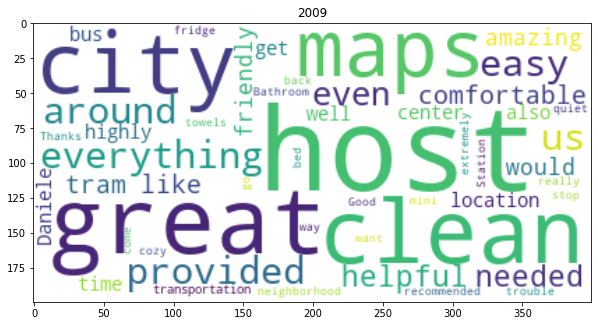

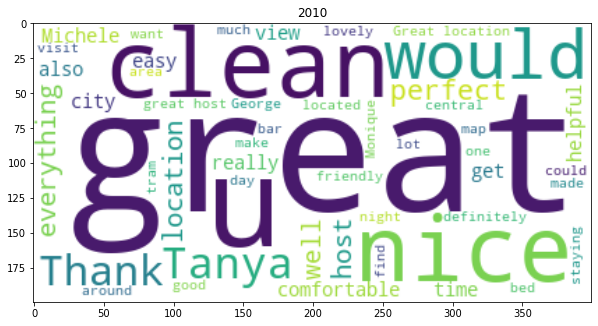

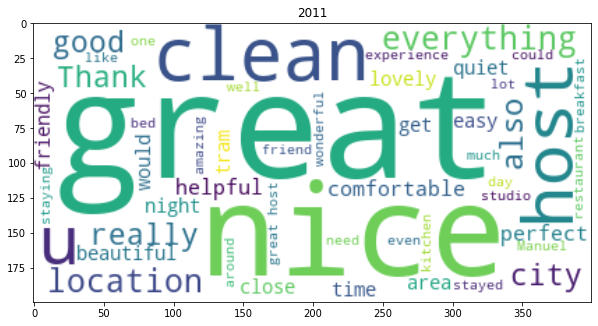

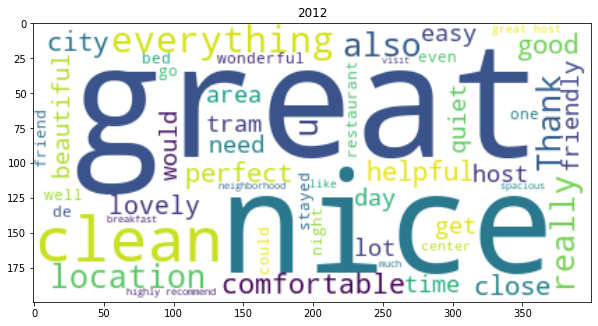

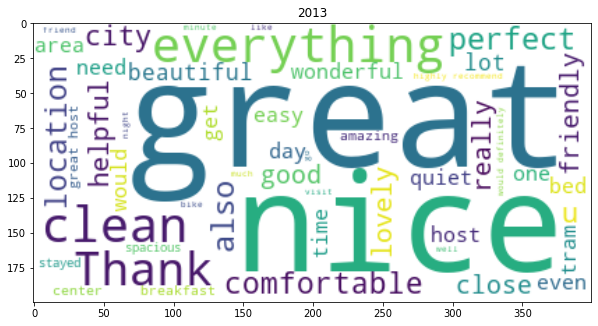

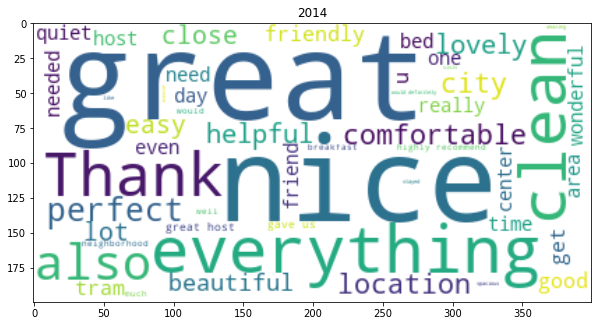

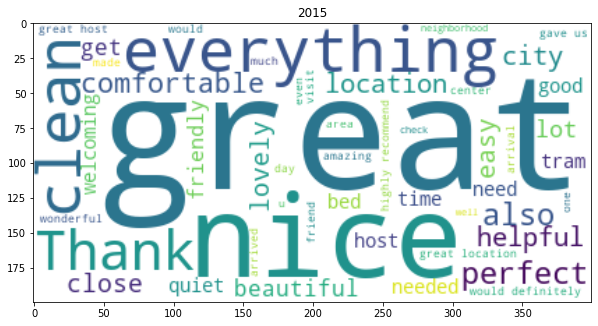

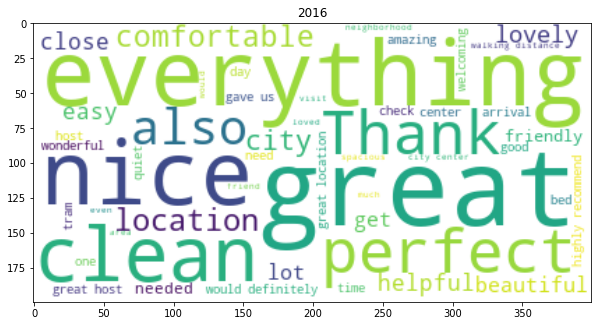

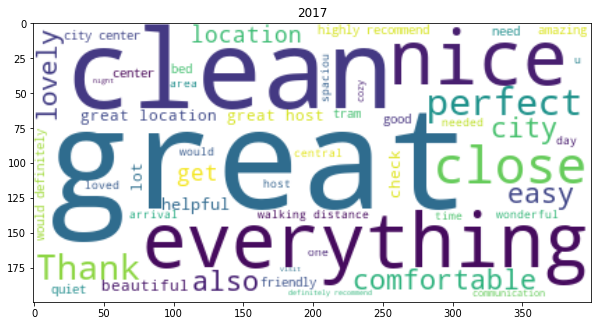

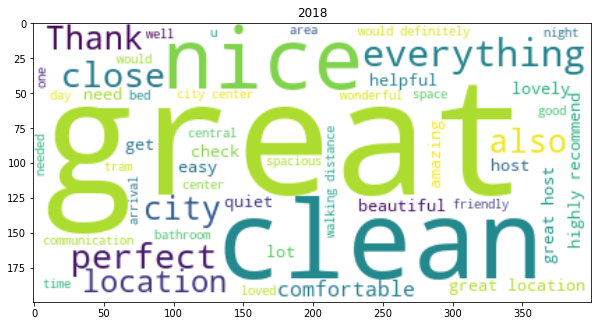

In [3]:
stopwords = stopwords.words('english')
newstops = ['Amsterdam', 'stay', 'place', 'apartment', 'flat', 'room', 'home', 'house', 'Daniel']
stopwords.extend(newstops)

wordcloud = WordCloud(background_color='white', max_words=50, stopwords=stopwords)

for year in np.arange(2009, 2019, 1):
    wordcloud.generate(' '.join(data_all[data_all['year'] == year]['comments'].astype(str)))
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(year)

Based on those frequent words, let's see if their importance for the Airbnb listing, measured by the proxy of the number of reviews per month. 

The line plot below suggests that, although the overall frequencies of the analyzed words is shrinking, some of them keep a high relevance such as 'host' and 'clean'. This, in turn, seem to reflect the most looked for characteristics in Airbnb bookings for this city. 

Text(0, 0.5, 'Frequency')

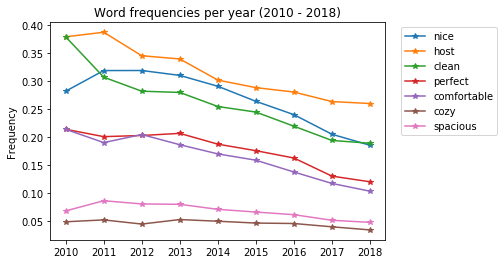

In [4]:
def word_frequencies(word):
    freqs = []
    for year in np.arange(2010, 2019, 1):
        freqs.append(sum([1 for i in data_all[data_all['year'] ==  year]['comments'].astype(str) if word in i])/len(data_all[data_all['year'] ==  year]['comments']))
    return freqs

obtained_freqs = []
for word in ['nice', 'host', 'clean', 'perfect', 'comfortable', 'cozy', 'spacious']:
    obtained_freqs.append(word_frequencies(word))
    
fig = plt.figure()
ax = fig.add_subplot(111)

for i, word in zip(np.arange(0, 7, 1), ['nice', 'host', 'clean', 'perfect', 'comfortable', 'cozy', 'spacious']):
    plt.plot(np.arange(2010, 2019, 1), obtained_freqs[i], marker='*', label=word)
plt.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
plt.title('Word frequencies per year (2010 - 2018)')
plt.ylabel('Frequency')

### Topic modeling

In [5]:
reviews = data_all['comments'].astype(str).values.tolist() 
reviews = [re.sub('\s+', ' ', review) for review in reviews]             

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-d3e897f83faa>:2: DeprecationWarning: invalid escape sequence \s
  reviews = [re.sub('\s+', ' ', review) for review in reviews]


In [6]:
def review_to_words(review):
    '''Tokenize reviews into words.'''
    for sentence in review:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

def remove_stopwords(texts):
    '''Remove stopwords.'''
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        
def make_bigrams(texts):
    '''Make bigrams.'''
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
            """https://spacy.io/api/annotation"""
            texts_out = []
            for sent in texts:
                doc = nlp(" ".join(sent))
                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            return texts_out

In [75]:
review_words = list(review_to_words(reviews))
stop_words = stopwords.words('english')
review_words_nostops = remove_stopwords(review_words)

bigram = gensim.models.Phrases(review_words_nostops, min_count=5, threshold=100) # higher threshold fewer phrases
bigram_mod = gensim.models.phrases.Phraser(bigram)


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # For word lemmatization

reviews_bigram = make_bigrams(review_words_nostops)

reviews_lemmatized = lemmatization(reviews_bigram)

id2word = corpora.Dictionary(reviews_lemmatized)
corpus = [id2word.doc2bow(text) for text in reviews_lemmatized]

In [91]:
 # Build LDA model with 4_topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [95]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.273146 -0.098944       1        1  38.567749
3      0.264775  0.163954       2        1  29.389345
6      0.038862 -0.395633       3        1  12.114810
4      0.096584  0.208263       4        1   6.317960
2     -0.162473  0.006381       5        1   5.196996
0     -0.167817  0.034194       6        1   3.079764
7     -0.193190  0.048283       7        1   2.774086
1     -0.149888  0.033502       8        1   2.559290, topic_info=           Term           Freq          Total Category  logprob  loglift
133   apartment  170426.000000  170426.000000  Default  30.0000  30.0000
78    recommend   96854.000000   96854.000000  Default  29.0000  29.0000
50        great  214138.000000  214138.000000  Default  28.0000  28.0000
11        place  210713.000000  210713.000000  Default  27.0000  27.0000
69         stay  199854.000000  199854.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
2019   stunning    1738.385742    1739.495728   Topic8  -4.7781   3.6648
982    charming    1686.937622    1688.047241   Topic8  -4.8082   3.6648
396       metro    1489.500366    1490.610229   Topic8  -4.9326   3.6647
942         der    1399.177002    1400.285889   Topic8  -4.9952   3.6646
95        super    1661.317871   37093.023438   Topic8  -4.8235   0.5596

[296 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
646       5  0.999786     accessible
402       6  0.999374  accommodating
132       8  0.999653            add
1013      6  0.999801       agreable
935       5  0.999796        airport
...     ...       ...            ...
6253      7  0.999563         willem
534       4  0.999930         window
169       1  0.999956      wonderful
417       4  0.999872           work
19        1  0.999986          would

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 7, 5, 3, 1, 8, 2])

### Price listing exploration

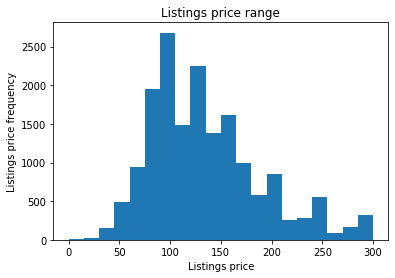

In [7]:
plt.hist(data_all.groupby('listing_id')['price'].mean(), bins = 20, range=(0, 300))
plt.ylabel('Listings price frequency')
plt.xlabel('Listings price')
plt.title('Listings price range')
plt.show()